### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

# Chapter 03: New dataset based on US8K 

# Urbansound8K for Autonomous Vehicles - US8K_AV

ASSUMPTION: to have the features saved as PKL file, run first the following notebooks for the dataset US8K:

* *01_Feature_extraction_exploration.ipynb*
* *02_PreProcessing_and_ML_modeling.ipynb* 

If you are interested only in the dataset US8K_AV, run this notebook until the end of Chapter 3.2 and make sure you have the following files from (GitHub: https://github.com/alf2001br/Master_thesis_Andre_Luiz_Florentino_project)

* MT_loadDataset.py (saved in the root directory) - This library will be called in this notebook to read the US8K data
* US8K_AV_silence.csv (saved in the US8K_AV folder) - This is the fold map for the new class 'silence' 

***

## Chapter 3.1 - Tailoring a new dataset from the primary data

### Loading the libraries


In [1]:
import warnings
import mimetypes
import os
import random
import pickle
import librosa
import librosa.display
import shutil
import glob

import pandas          as pd
import numpy           as np
import seaborn         as sns
import IPython.display as ipd
import soundfile       as sf

from matplotlib  import pyplot as plt


# Solution to play .ogg files in the IPython 
# https://stackoverflow.com/questions/39077987/ipython-display-audio-cannot-correctly-handle-ogg-file-type

SEED = 1000

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

In [2]:
# Global variables

current_path = os.getcwd()

# Values for feature extraction
threshold   = 60
frames      = 44
time_length = 4
SR          = 22050

# For the picture names
pic_first_name = '03_New_dataset_US8K_AV_'

dict_list    = []
path_primary = os.path.join(current_path, "_dataset", "US8K")
path_US8K_AV = os.path.join(current_path, "_dataset", "US8K_AV")
path_models  = os.path.join(current_path, "US8K_AV_saved_models")
path_pic     = os.path.join(current_path, "US8K_AV_results")


# Check if the folder exists, if not, create it
if not os.path.exists(path_US8K_AV):
    os.makedirs(path_US8K_AV)
    
# Check if the folder exists, if not, create it
if not os.path.exists(path_models):
    os.makedirs(path_models)

# Check if the folder exists, if not, create it
if not os.path.exists(path_pic):
    os.makedirs(path_pic)

subfolders      = next(os.walk(path_primary))[1]
nom_dataset     = 'US8K_AV'
csv_file        = 'US8K_AV.csv'
fold            = '1'

pkl_features          = 'US8K_AV_features_original.pkl'
pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large

In [3]:
# Export the dataframe as CSV file
def exportCSV(path: str, db: pd.DataFrame, filename: str):

    os.chdir(path)
    db.to_csv(filename)
    print("\nCSV exported.\nCheck the folder", path)

In [4]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [5]:
from MT_loadDataset import loadDataset

In [6]:
loader = loadDataset(path_primary)
db     = loader.db_B

print("\nClasses:\n--------------------")
print(db["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(db["File_name"])))
print("Total number of AUDIO files...........: ", len(db))
db


CSV exported.
Check the folder :  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K

Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Total number of unique files..........:  8732
Total number of AUDIO files...........:  8732


,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


In [7]:
for col in db.columns:
    print(col)

Fold
Folder_name
Class_OHEV
Class_categorical
File_name
Path
classID
fsID
start
end
salience


In [8]:
def check_db(db: pd.DataFrame):
    
    numeric_cols = db.select_dtypes(include=['int64', 'float64'])

    # If there are no numeric columns, this will print an empty DataFrame
    print(numeric_cols)

    # If you want to check if there are any numeric columns
    if numeric_cols.empty:
        print("No int64 or float64 columns found in the DataFrame.")
    else:
        print("DataFrame contains int64 or float64 columns.")

In [9]:
check_db(db)

      Fold  classID    fsID       start         end  salience
0        5        3  100032    0.000000    0.317551         1
1        5        2  100263   58.500000   62.500000         1
2        5        2  100263   60.500000   64.500000         1
3        5        2  100263   63.000000   67.000000         1
4        5        2  100263   68.500000   72.500000         1
...    ...      ...     ...         ...         ...       ...
8727     7        1   99812  159.522205  163.522205         2
8728     7        1   99812  181.142431  183.284976         2
8729     7        1   99812  242.691902  246.197885         2
8730     7        1   99812  253.209850  255.741948         2
8731     7        1   99812  332.289233  334.821332         2

[8732 rows x 6 columns]
DataFrame contains int64 or float64 columns.


In [10]:
path_primary, subfolders

('C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master\\_dataset\\US8K',
 ['fold1',
  'fold10',
  'fold2',
  'fold3',
  'fold4',
  'fold5',
  'fold6',
  'fold7',
  'fold8',
  'fold9'])

### Removing irrelevant classes and merging less relevant classes of the US8K dataset

Subjective evaluation of the classes, including the datasets ESC-10 and BDLib2.

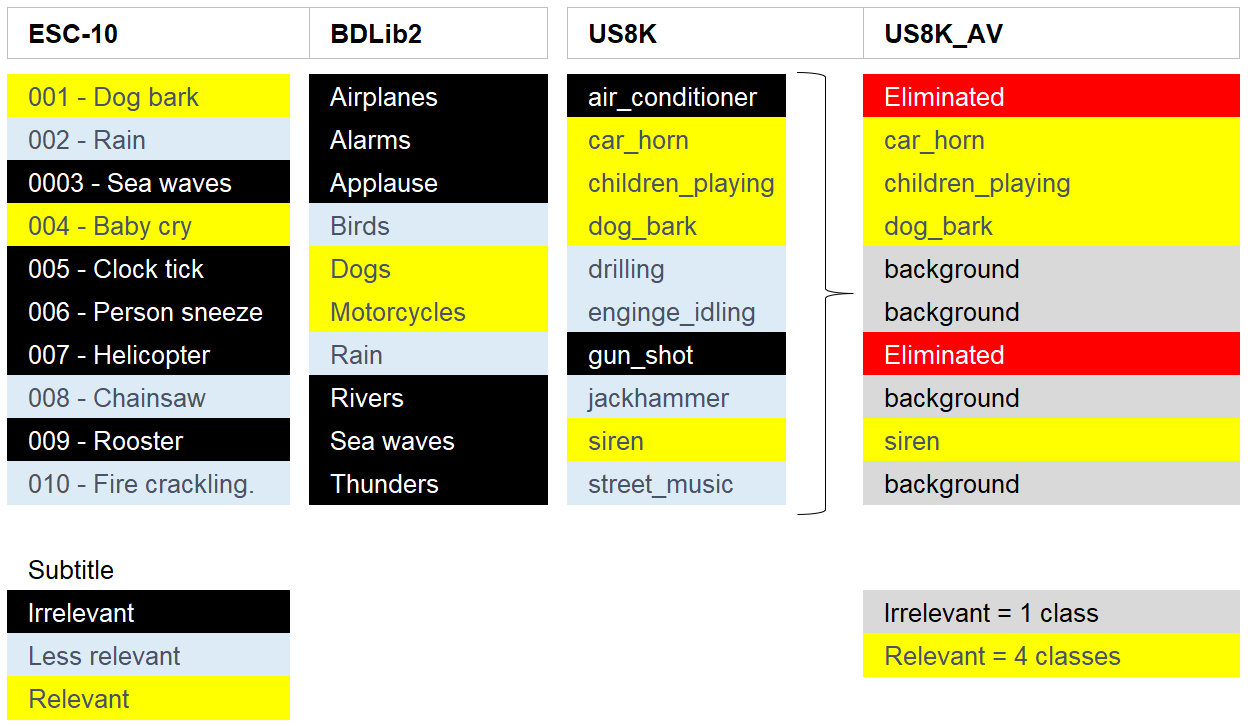

Class removed from the dataset:

* air_conditioner     1000
* gun_shot             374

In [11]:
print(f'Samples after removing the 2 classes: {8732-1000-374}.')

Samples after removing the 2 classes: 7358.


In [12]:
db_new = db[~db['Class_categorical'].isin(['gun_shot', 'air_conditioner'])]
db_new

,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


In [13]:
print(db_new["Class_categorical"].value_counts())
print("\nTotal number of unique sound files.........: ", len(np.unique(db_new["File_name"])))

Class_categorical
dog_bark            1000
children_playing    1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique sound files.........:  7358


In [14]:
classes_to_remove = ['drilling', 'jackhammer', 'street_music', 'engine_idling']

# Iterate over the classes and remove 750 random samples from each class deemed less relevant
for class_name in classes_to_remove:
    class_data     = db_new[db_new['Class_categorical'] == class_name]
    random_samples = class_data.sample(n = 750, random_state = SEED) 
    db_new         = db_new.drop(random_samples.index)

In [15]:
print(db_new["Class_categorical"].value_counts())
print("\nTotal number of unique sound files.........: ", len(np.unique(db_new["File_name"])))

Class_categorical
dog_bark            1000
children_playing    1000
siren                929
car_horn             429
street_music         250
engine_idling        250
jackhammer           250
drilling             250
Name: count, dtype: int64

Total number of unique sound files.........:  4358


In [16]:
class_data

,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
122,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,0.000000,4.000000,1
123,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,0.500000,4.500000,1
124,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,5.000000,9.000000,1
125,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,5.500000,9.500000,1
126,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,6.000000,10.000000,1
...,...,...,...,...,...,...,...,...,...
8532,2,fold2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,94710,0.500000,4.500000,1
8533,2,fold2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,94710,1.000000,5.000000,1
8534,2,fold2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,94710,1.500000,5.500000,1
8535,2,fold2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,94710,23.239672,25.325283,1


In [17]:
class_mapping = {'drilling': 'background',
                 'jackhammer': 'background',
                 'engine_idling': 'background',
                 'street_music': 'background'}

# Rename the classes using the mapping dictionary
db_new['Class_categorical'] = db_new['Class_categorical'].replace(class_mapping)

In [18]:
print(db_new["Class_categorical"].value_counts())
print("\nTotal number of unique sound files.........: ", len(np.unique(db_new["File_name"])))

Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique sound files.........:  4358


In [19]:
exportCSV(path_US8K_AV, db_new, 'US8K_merged.csv')


CSV exported.
Check the folder C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV


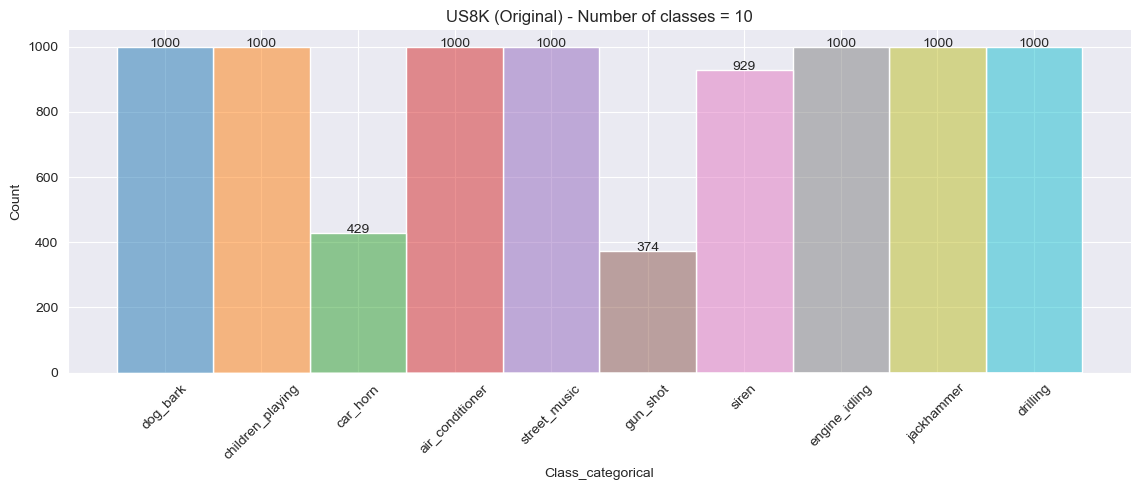

In [20]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K (Original) - Number of classes = ' + str(len(pd.Series(db['Class_categorical']).unique()))
g = sns.displot(db,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

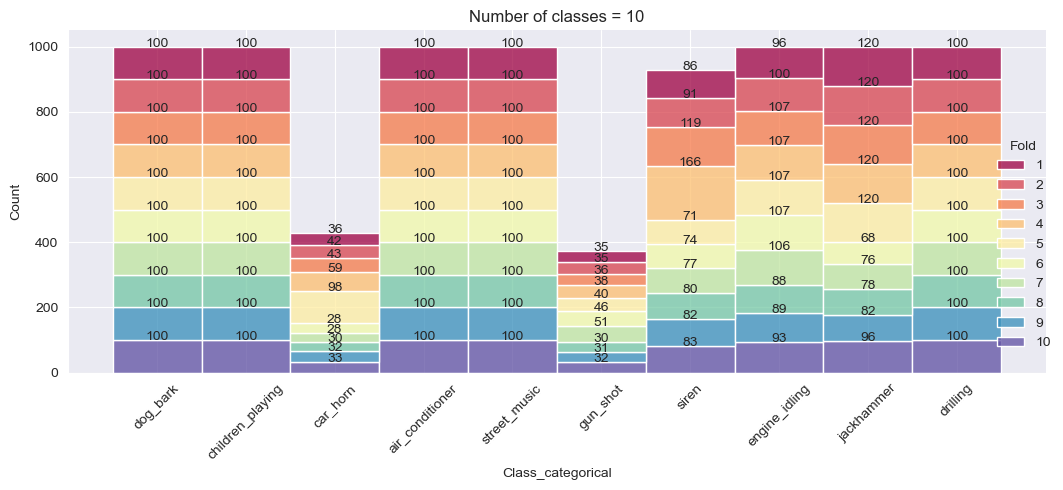

In [21]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'Number of classes = ' + str(len(pd.Series(db['Class_categorical']).unique()))
g = sns.displot(db, x='Class_categorical', hue='Fold',height = 5, aspect = 2, multiple='stack', palette='Spectral').set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = int(p.get_height())
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
#g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

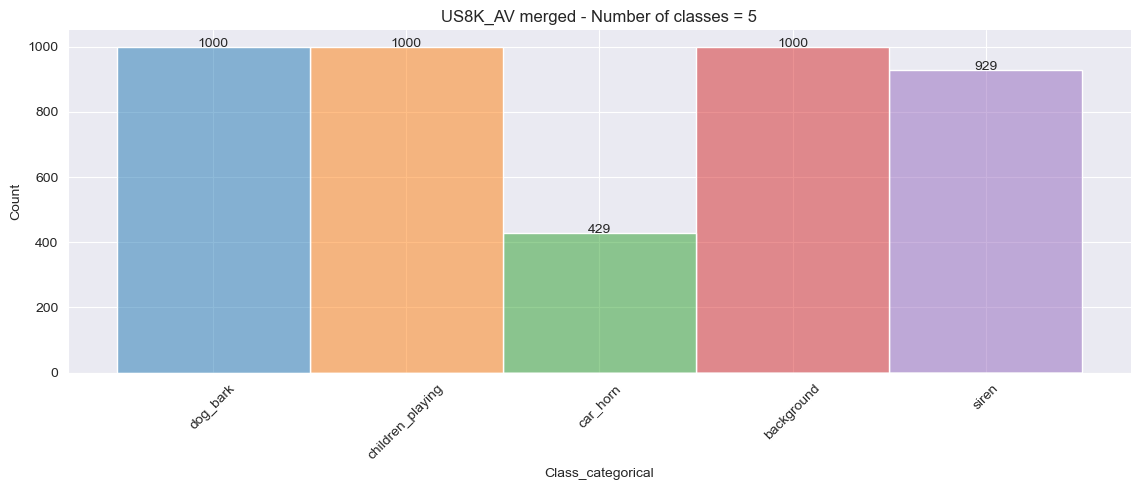

In [22]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K_AV merged - Number of classes = ' + str(len(pd.Series(db_new['Class_categorical']).unique()))
g = sns.displot(db_new,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

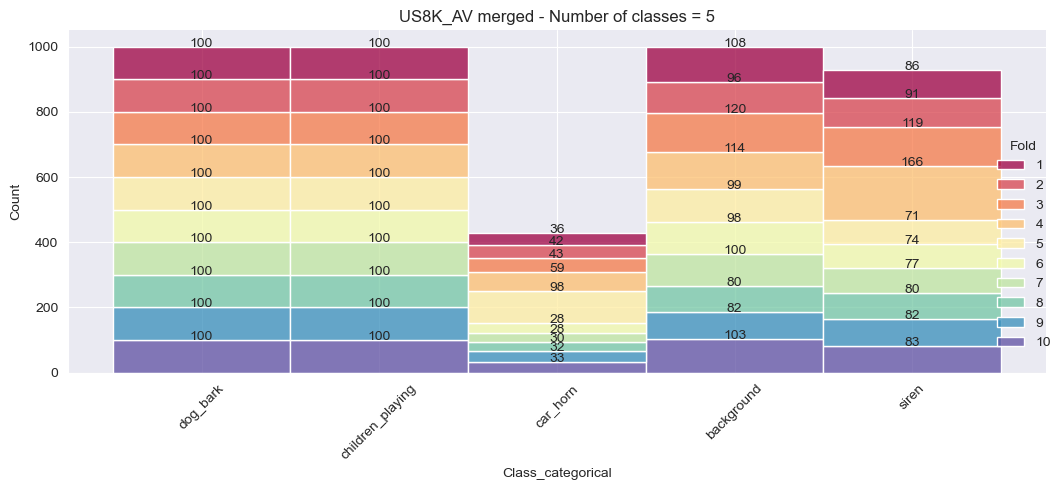

In [23]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K_AV merged - Number of classes = ' + str(len(pd.Series(db_new['Class_categorical']).unique()))
g = sns.displot(db_new, x='Class_categorical', hue='Fold', height = 5, aspect = 2, multiple='stack', palette='Spectral').set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = int(p.get_height())
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
#g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

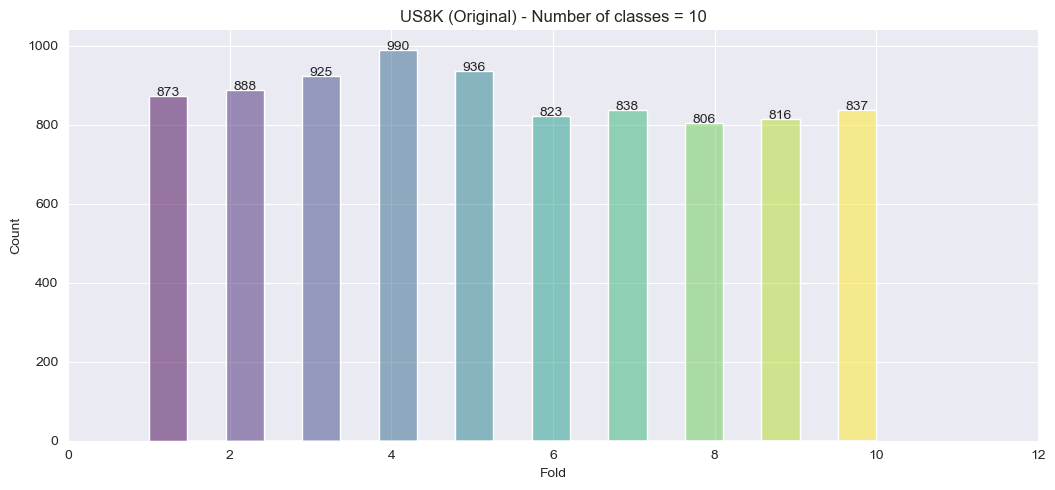

In [24]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K (Original) - Number of classes = ' + str(len(pd.Series(db['Class_categorical']).unique()))
db_sorted = db.sort_values('Fold')
g = sns.displot(db_sorted, x='Fold', hue='Fold', height = 5, aspect = 2, palette='viridis').set(title=gTitle)
g.set_xticklabels(rotation=0)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

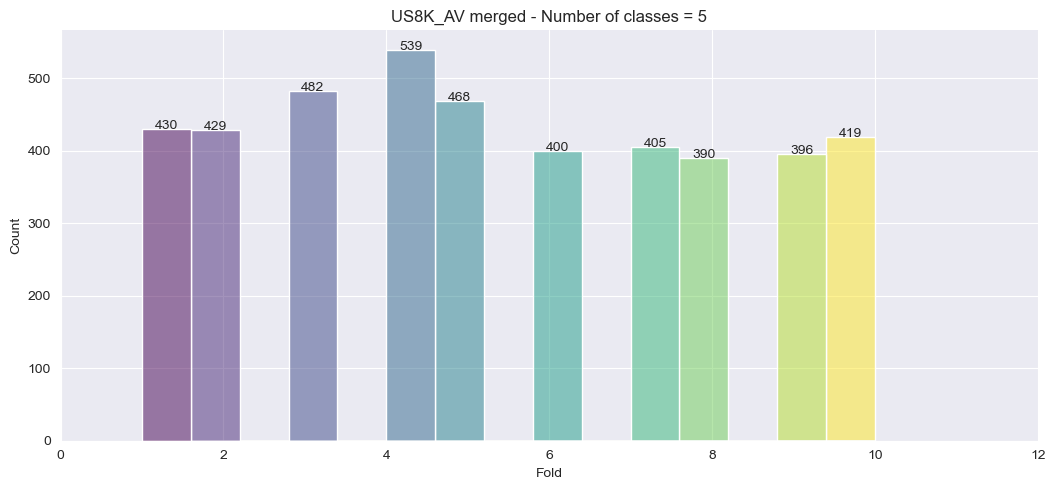

In [25]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K_AV merged - Number of classes = ' + str(len(pd.Series(db_new['Class_categorical']).unique()))
db_sorted = db_new.sort_values('Fold')
g = sns.displot(db_sorted, x='Fold', hue='Fold', height = 5, aspect = 2, palette='viridis').set(title=gTitle)
g.set_xticklabels(rotation=0)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = int(p.get_height())
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

In [26]:
for fold in range (1,11):
    print(len(db_new[db_new['Fold'] == fold]))

430
429
482
539
468
400
405
390
396
419


In [27]:
db_new.drop(columns = 'Class_OHEV', inplace = True)

In [28]:
def OHEV(db_B: pd.DataFrame):
    df_class  = db_B['Class_categorical']
    class_enc = np.array(pd.get_dummies(df_class, columns = [str], dtype=int))
    db_B.insert(loc = 2, column = 'Class_OHEV', value = class_enc.tolist())
    
    return db_B

In [29]:
# Update the OHEV with the new classes

db_new = OHEV(db_new)

In [30]:
db_new

,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


In [31]:
type(db_new['Class_OHEV'][0][0])

int

In [32]:
# Overwrite the .CSV file with the updated OHEV for the merged classes

exportCSV(path_US8K_AV, db_new, 'US8K_merged.csv')
del db_new


CSV exported.
Check the folder C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV


In [33]:
# Testing loading the dataset metadata from the saved file

#loadDataset = loadDataset(path_US8K_AV)
#db_new      = loadDataset.db_B

db_new = pd.read_csv(os.path.join(path_US8K_AV, 'US8K_merged.csv'), dtype={'Fold': str})
db_new = db_new.drop('Unnamed: 0', axis=1)

print("\nClasses:\n--------------------")
print(db_new["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(db_new["File_name"])))
print("Total number of AUDIO files...........: ", len(db_new))
db_new


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4358
Total number of AUDIO files...........:  4358


,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
4353,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
4354,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
4355,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
4356,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


## Chapter 3.2 - Constructing the new class 'silence'

In [34]:
# New globals

path_freeS = os.path.join(current_path, '_dataset', 'US8K_AV', 'Freesound')
path_conv  = os.path.join(current_path, '_dataset', 'US8K_AV', 'Freesound_conv')
path_norm  = os.path.join(current_path, '_dataset', 'US8K_AV', 'Freesound_norm')

# Create output folder if it doesn't exist
if not os.path.exists(path_freeS):
    os.makedirs(path_freeS)
    
if not os.path.exists(path_conv):
    os.makedirs(path_conv)
    
if not os.path.exists(path_norm):
    os.makedirs(path_norm)

At this moment, the US8K_AV folder structure should look like this:

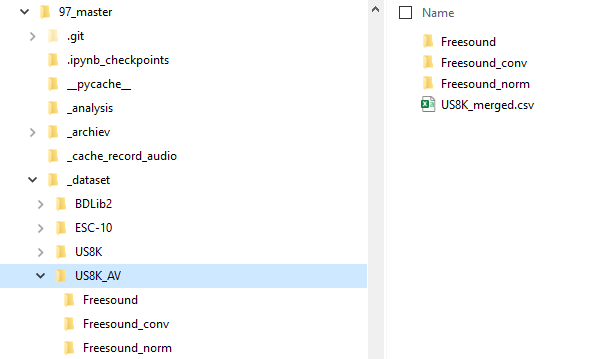

### Download silence audio files from Freesound.org

There is no free lunch here. <u>One has to download file by file and save them in the folder Freesound.</u>

**33 files must be downloaded**

**readingroom.aif**

Binaural recording of the working silence of a research library, with its coughs, the movement of bodies and furniture, the turning of pages and the clicks of keyboards, even the unexpectedly obtrusive swallowing of the sound recordist. Near the end a recorded announcement informs readers that the reading room will shortly be closing. Recorded in Humanities 1 Reading Room, British Library, London, 25 September 2010.

https://freesound.org/people/bulldozia/sounds/107367/download/107367__bulldozia__readingroom.aiff
***
**silence 06-09-2012.wav**

The silence on the Alps.

https://freesound.org/people/wescwave/sounds/170017/download/170017__wescwave__silence-06-09-2012.wav
***
**RoomTone EmptyClassRoom 01 LONG 130626_00.flac**

Room-tone empty class-room in almost empty building in quiet street.
Some strange noise that sounds like shifting chairs in other room, but it's noise from the air-conditioning system. A little noise from outdoor. The air-flow whiz.
Room-size: 8x7x3 meter.

https://freesound.org/people/klankbeeld/sounds/192666/download/192666__klankbeeld__roomtone-emptyclassroom-01-long-130626_00.flac
***
**silence vinyl.wav**

Sound of an empty record played on a turntable.

https://freesound.org/people/il112/sounds/196153/download/196153__il112__silence-vinyl.wav
***
**silence.flac**

Silence underwater in a bathtub

https://freesound.org/people/wjoojoo/sounds/254197/download/254197__wjoojoo__silence.flac
***
**room-tone suburb 01 MS 150403_0573.wav**

MS recorded room-tone in apartment in suburban setting.

https://freesound.org/people/klankbeeld/sounds/268982/download/268982__klankbeeld__room-tone-suburb-01-ms-150403_0573.wav
***
**paving_silence.wav**

Room tone for the Footsteps pavement sound pack.

https://freesound.org/people/sturmankin/sounds/273135/download/273135__sturmankin__paving_silence.wav
***
**silence.wav**

No description.

https://freesound.org/people/jillvogel/sounds/277326/download/277326__jillvogel__silence.wav
***
**soil_silence.wav**

Room tone for the Footsteps soil sound pack.

https://freesound.org/people/sturmankin/sounds/278940/download/278940__sturmankin__soil_silence.wav
***
**Silence- stereo and high quality**

This a free, 10 minute demo of extremely high quality silence. It is stereo and has a high (96000) sample rate, and is probably the best quality silence sample around.

The poor-quality MP3 hosted on freesound is simply not enough. Download it and listen to the Flac to hear it as it was intended...

https://freesound.org/people/kwahmah_02/sounds/320807/download/320807__kwahmah_02__silence-stereo-and-high-quality.flac
***
**AMBLM tv studio room tone ambience noise lights off xy.wav**

Roomtone / silence / ambience / presence recorded in a tv studio with all lights off. Zoom H6 XY mics.

https://freesound.org/people/LudwigMueller/sounds/329550/download/329550__ludwigmueller__amblm-tv-studio-room-tone-ambience-noise-lights-off-xy.wav
***
**indoor_ apartments_hall_noise 2**

Hall in concrete prefab house, television sound coming from closed apartments.

https://freesound.org/people/Kostrava/sounds/333960/download/333960__kostrava__indoor_-apartments_hall_noise-2.wav
***
**top_of_hill_estialescq_minimal_soundscape.wav**

A quiet afternoon from the top of a hill near Estialescq.

https://freesound.org/people/joseph.larralde/sounds/352510/download/352510__josephlarralde__top_of_hill_estialescq_minimal_soundscape.wav
***
**Car_Ambiance_Edited.wav**

This is ambiance taken from the inside of a moving car. It captures accelerating, breaking, stopping, indicating and gear changing.

https://freesound.org/people/AmberdeMeillon/sounds/443044/download/443044__amberdemeillon__car_ambiance_edited.wav
***
**Silence Ambience.wav**

Silence ambience recorded with a boom mic in an open space in a surbub.

https://freesound.org/people/ayubwaguma/sounds/445762/download/445762__ayubwaguma__silence-ambience.wav
***
**dunes NL March 01 190328_1325.wav**

A very quiet day in the dunes in March in the south of the Netherlands...

https://freesound.org/people/klankbeeld/sounds/465062/download/465062__klankbeeld__dunes-nl-march-01-190328_1325.wav
***
**night.wav**

Recorded in the middle of the night and the great thing is: no man-made sounds.

What you hear is the river Tay in the distance and some Oystercatchers and apart from that: nothing! How brilliant in these days.

https://freesound.org/people/inchadney/sounds/476294/download/476294__inchadney__night.wav
***
**Cemetery Valencia Ambience 1**

Ambience from Valencia (Spain) City Cemetery.

https://freesound.org/people/emilijoan/sounds/506954/download/506954__emilijoan__cemetery-valencia-ambience-1.wav
***
**silence movie theater.wav**

Empty movie theater ambient.

https://freesound.org/people/IsraGallo/sounds/514305/download/514305__isragallo__silence-movie-theater.wav
***
**pernett_alex_baja_fidelidad_silencio.aif**

It struck me that this is the quietest it can be in my house, suppose you can't hear the birds, the cats, the traffic, us, nothing, but still there was no silence like I had. you imagine...

https://freesound.org/people/artesmediales/sounds/515112/download/515112__artesmediales__pernett_alex_baja_fidelidad_silencio.aiff
***
**empty shopping mall creepy corona silence sound effect**

Empty shopping mall creepy corona silence sound effect. recorded with sony pcm d100.

https://freesound.org/people/Garuda1982/sounds/544309/download/544309__garuda1982__empty-shopping-mall-creepy-corona-silence-sound-effect.wav
***
**Concert Hall Silence Ambiance.mp3**

A polite crowd making minute noises in an echoing concert hall. Made of multiple audio clips spliced together, in hopes that most transitions are seamless, and those that aren't can be easily edited. Taken with a black Sony IC recorder, at Boettcher Concert Hall with the Denver Young Artists Orchestra. Use however you wish. God bless!

https://freesound.org/people/FunWithSound/sounds/588400/download/588400__funwithsound__concert-hall-silence-ambiance.mp3
***
**empty room**

The sound of an empty room. Recorded with zoom h6n stereo.

https://freesound.org/people/frodeims/sounds/611590/download/611590__frodeims__empty-room.wav
***
**Airplane_Silent landscape.wav**

Airplane flying low over a silent natural landscape.
Recorded in the natural park of Hautes Fagnes in Belgium.

Binaural (DPA4060)

https://freesound.org/people/Mar.Sounds/sounds/627058/download/627058__marsounds__airplane_silent-landscape.wav
***
**Ambiance_Countryside (silence).wav**

Silent countryside ambiance, with birds and low highway rumble in the distance.
X/Y stereo (Zoom H5)

https://freesound.org/people/Mar.Sounds/sounds/627063/download/627063__marsounds__ambiance_countryside-silence.wav
***
**Car ambience OWI.wav**

The empty sound in a car when it is off and nobody is talking.

https://freesound.org/people/Jarryd28/sounds/655896/download/655896__jarryd28__car-ambience-owi.wav
***
**Ambience outside the car.wav**

The atmosphere outside a car in a field in the suburbs. Morning and spring outside.

https://freesound.org/people/Kim_Kimovna/sounds/693464/download/693464__kim_kimovna__ambience-outside-the-car.wav
***
**parkambience.wav**

Some park ambience. No people, just trees, birds and insects - some cars in the distance.

https://freesound.org/people/NistuGgner/sounds/699660/download/699660__nistuggner__parkambience.wav
***
**Silent Room Ambience_OWI**

A room covered in silence in the middle of the night, it has background noises to add to the effect.

https://freesound.org/people/Nyakallo_Moloi_21100482/sounds/708165/download/708165__nyakallo_moloi_21100482__silent-room-ambience_owi.wav
***
**Parking Lot Ambience: Cars driving by, people talking in the distance, tires on pavement, honking of car horn, low rumble. Recorded with ZoomH6 in stereo, with rifle microphone.**

Late afternoon recording with loads of vehicles passing and parking in Centurion Mall's parking lot. People are talking in the distance and car horns can be heard. The low rumble of the aircon machines are heard.

https://freesound.org/people/RileyB711/sounds/708192/download/708192__rileyb711__parking-lot-ambience-cars-driving-by-people-talking-in-the-distance-tires-on-pavement-honking-of-car-horn-low-rumble-recorded-with-zoomh6-in-stereo-with-rifle-microphone.wav
***
**Above the road/treet - Hon Kong ambience**

Recording from above the street with cars and buses passing by.

https://freesound.org/people/ivoliYT/sounds/723311/download/723311__ivoliyt__above-the-roadtreet-hon-kong-ambience.wav
***
**Ambience_city**

Ambience sound in sao paulo, distance sound of cars.


https://freesound.org/people/itabitencourt/sounds/727510/download/727510__itabitencourt__ambience_city.wav
***
**Street Ambience Day - trains in the distance - Melbourne, Australia**

Street Ambience Day - cars going by and train boom gates in the distance - Melbourne, Australia. Suburban street but moderately busy.

https://freesound.org/people/Sassaby/sounds/736583/download/736583__sassaby__street-ambience-day-trains-in-the-distance-melbourne-australia.wav
***

In [35]:
def convert_audio(file_path, output_path):
       
    # Load audio file
    y, _ = librosa.load(file_path, sr=SR, mono=True)
    
    duration = librosa.get_duration(y=y, sr=SR)

    # Save as .wav with 16-bit PCM encoding
    sf.write(output_path, y, SR, subtype='PCM_16')
    
    print(f'Duration of the loaded audio...: {duration:2f} s')
    
    return duration

In [36]:
## Iterate over all files in the input folder, rename them keeping only the Freesound ID, and convert them to WAV format

total_duration = 0

for file_name in os.listdir(path_freeS):
    file_path = os.path.join(path_freeS, file_name)
    print(file_name)
    
    # Skip directories and non-audio files based on extension
    if not os.path.isfile(file_path) or not file_name.lower().endswith(('.wav', '.flac', '.aiff', '.mp3')):
        continue
    
    # Define output path with .wav extension
    output_path = os.path.join(path_conv, os.path.splitext(file_name[0:6])[0] + '.wav')
    
    # Convert and save the audio file
    duration = convert_audio(file_path, output_path)
    total_duration = total_duration + duration
    

print("\nConversion complete!\n")
print(f'Total duration of the loaded audio...: {total_duration/3600:2f} h')

107367__bulldozia__readingroom.aiff
Duration of the loaded audio...: 273.000499 s
170017__wescwave__silence-06-09-2012.wav
Duration of the loaded audio...: 85.481678 s
192666__klankbeeld__roomtone-emptyclassroom-01-long-130626_00.flac
Duration of the loaded audio...: 776.557778 s
196153__il112__silence-vinyl.wav
Duration of the loaded audio...: 24.000000 s
254197__wjoojoo__silence.flac
Duration of the loaded audio...: 28.003265 s
268982__klankbeeld__room-tone-suburb-01-ms-150403_0573.wav
Duration of the loaded audio...: 148.559864 s
273135__sturmankin__paving_silence.wav
Duration of the loaded audio...: 115.505578 s
277326__jillvogel__silence.wav
Duration of the loaded audio...: 3.544490 s
278940__sturmankin__soil_silence.wav
Duration of the loaded audio...: 115.505578 s
320807__kwahmah_02__silence-stereo-and-high-quality.flac
Duration of the loaded audio...: 599.957007 s
329550__ludwigmueller__amblm-tv-studio-room-tone-ambience-noise-lights-off-xy.wav
Duration of the loaded audio...: 

In [37]:
def split_audio(file_path, output_base_name):
    dfLin = pd.DataFrame()
    
    # Load audio file
    y, _ = librosa.load(file_path, sr=SR, mono=True)
    
    # Define interval length (4 seconds)
    interval_length = 4 * SR
    
    # Calculate number of intervals (limit to 20)
    num_intervals = min(len(y) // interval_length + (1 if len(y) % interval_length != 0 else 0), 20)
    
    for i in range(num_intervals):
        start_sample = i * interval_length
        end_sample = min((i + 1) * interval_length, len(y))
        
        # Extract the segment
        y_segment = y[start_sample:end_sample]
        
        # Define output path for each segment with sequential numbering
        output_path = os.path.join(path_norm, f"{output_base_name}-{i+1}.wav")
        
        # Save the segment as .wav with 16-bit PCM encoding
        sf.write(output_path, y_segment, SR, subtype='PCM_16')

        # criar dados para o arquivo 
        fim = float((i+1) * 4)
        ini = float(fim - 4)
        sfn = output_base_name + '-10-0-'+str(i+1)+'.wav' #Class ID set to 10 to avoid clash with the primary data
        fn  = output_base_name + '-' + str(i+1)+'.wav'
        dfLin = pd.concat([dfLin,
                           pd.DataFrame({"File_name":[fn],"slice_file_name":[sfn],"fsID":[output_base_name],"start":[ini],"end":[fim],"salience":[1],"classID":[10], "class":["silence"]})])
  
    return dfLin

File name and metadata structure according to the US8K dataset (primary data).

Source: https://urbansounddataset.weebly.com/urbansound8k.html#10foldCV

***

**slice_file_name**: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

**fsID**:
The Freesound ID of the recording from which this excerpt (slice) is taken

**start**:
The start time of the slice in the original Freesound recording

**end**:
The end time of slice in the original Freesound recording

**salience**:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

**fold**:
The fold number (1-10) to which this file has been allocated.

In [38]:
# Iterate over all converted files in the output folder and split them into 4-second intervals. 
# Write a dataframe for the metadata

dfMD = pd.DataFrame()
for file_name in os.listdir(path_conv):
    file_path = os.path.join(path_conv, file_name)
    
    # Skip directories and non-audio files based on extension
    if not os.path.isfile(file_path) or not file_name.lower().endswith('.wav'):
        continue
    
    # Define base name for split files (without extension)
    output_base_name = os.path.splitext(file_name)[0]
    
    # Split and save the audio file into intervals
    dfMD = pd.concat([dfMD, split_audio(file_path, output_base_name)])
    
print('559 files expected.\n')
print(f'{len(next(os.walk(path_norm))[2])} files created.')

559 files expected.

559 files created.


In [39]:
dfMD

,File_name,slice_file_name,fsID,start,end,salience,classID,class
0,107367-1.wav,107367-10-0-1.wav,107367,0.0,4.0,1,10,silence
0,107367-2.wav,107367-10-0-2.wav,107367,4.0,8.0,1,10,silence
0,107367-3.wav,107367-10-0-3.wav,107367,8.0,12.0,1,10,silence
0,107367-4.wav,107367-10-0-4.wav,107367,12.0,16.0,1,10,silence
0,107367-5.wav,107367-10-0-5.wav,107367,16.0,20.0,1,10,silence
...,...,...,...,...,...,...,...,...
0,736583-16.wav,736583-10-0-16.wav,736583,60.0,64.0,1,10,silence
0,736583-17.wav,736583-10-0-17.wav,736583,64.0,68.0,1,10,silence
0,736583-18.wav,736583-10-0-18.wav,736583,68.0,72.0,1,10,silence
0,736583-19.wav,736583-10-0-19.wav,736583,72.0,76.0,1,10,silence


### WAV files are now separated into 10 folds.

Now the files were separated into the 10 folds manually in order to create the .CSV file (US8K_AV_silence.csv) as a fold map for the next cell.

This manually process DOESN'T have to be executed again. The .CSV file and the next code lines are enough.

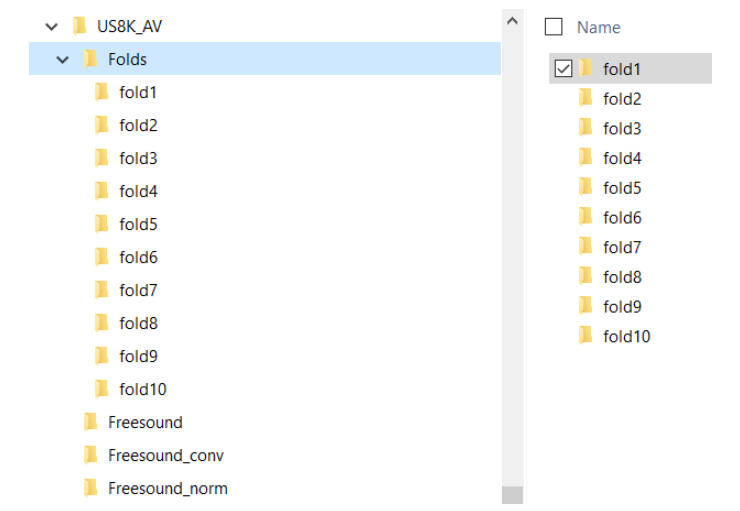

In [40]:
current_path

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master'

Make sure you download the file *US8K_AV_silence.csv* from the **GitHub**:

https://github.com/alf2001br/Master_thesis_Andre_Luiz_Florentino_project/blob/main/US8K_AV_silence.csv

In [41]:
dfSilence = pd.read_csv(os.path.join(current_path, 'US8K_AV_silence.csv'))
dfSilence

,Unnamed: 0,Fold,Folder_name,Class_categorical,File_name,Path
0,0,1,fold1,silence,107367-1.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-1.wav
1,1,1,fold1,silence,107367-10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-10.wav
2,2,1,fold1,silence,107367-11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-11.wav
3,3,1,fold1,silence,107367-12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-12.wav
4,4,1,fold1,silence,107367-13.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-13.wav
...,...,...,...,...,...,...
545,545,9,fold9,silence,708192-10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-10.wav
546,546,9,fold9,silence,708192-11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-11.wav
547,547,9,fold9,silence,708192-12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-12.wav
548,548,9,fold9,silence,708192-8.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-8.wav


In [42]:
# Preparation for the metadata creation (merge dfMD and dfSilence)
# 9 files were ignored on purpose in order to balance the dataset classes

dfMD = dfMD.merge(dfSilence, how='inner', on='File_name')
dfMD['Fold']= dfMD['Fold'].astype("int")
dfMD.rename(columns={'Fold': 'fold'}, inplace = True)
dfMD

,File_name,slice_file_name,fsID,start,...,fold,Folder_name,Class_categorical,Path
0,107367-1.wav,107367-10-0-1.wav,107367,0.0,...,1,fold1,silence,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-1.wav
1,107367-2.wav,107367-10-0-2.wav,107367,4.0,...,1,fold1,silence,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-2.wav
2,107367-3.wav,107367-10-0-3.wav,107367,8.0,...,1,fold1,silence,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-3.wav
3,107367-4.wav,107367-10-0-4.wav,107367,12.0,...,1,fold1,silence,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-4.wav
4,107367-5.wav,107367-10-0-5.wav,107367,16.0,...,1,fold1,silence,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-5.wav
...,...,...,...,...,...,...,...,...,...
545,736583-16.wav,736583-10-0-16.wav,736583,60.0,...,4,fold4,silence,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold4\736583-10-0-16.wav
546,736583-17.wav,736583-10-0-17.wav,736583,64.0,...,4,fold4,silence,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold4\736583-10-0-17.wav
547,736583-18.wav,736583-10-0-18.wav,736583,68.0,...,4,fold4,silence,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold4\736583-10-0-18.wav
548,736583-19.wav,736583-10-0-19.wav,736583,72.0,...,4,fold4,silence,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold4\736583-10-0-19.wav


In [43]:
print('Copying ...')
for index, row in dfMD.iterrows():
    org  = os.path.join(current_path,'_dataset','US8K_AV','Freesound_norm',row['File_name'])
    des  = os.path.join(current_path,'_dataset','US8K_AV',row['Folder_name'])
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(des):
        os.makedirs(des)

    # copying the files to the destination directory
    shutil.copy2(org, os.path.join(des,row['File_name']))
    os.rename(os.path.join(des,row['File_name']), os.path.join(des,row['slice_file_name']))    

print('Finished ...')

Copying ...
Finished ...


In [44]:
# Method to read the folders, sound files and create the dataframe

def readDoc(path: str, subfolders: str):
     
    sound_files = []
    for folder in subfolders:
        os.chdir(os.path.join(path, folder))

        sounds = (glob.glob('*.wav'))
        sound_files.append(sounds)
        for s in sounds:
            row_dict = {'Fold': str(folder.split('fold')[1]),
                        'Folder_name': folder,
                        'Class_categorical': 'silence',
                        'File_name': s,
                        'Path': os.path.join(path, folder,s)}
            dict_list.append(row_dict)
    
    return pd.DataFrame.from_dict(dict_list), sound_files

In [45]:
# Update the file US8K_AV_silence.csv with the current path of the user. 
# This updating is required for the statistic section.

dfSilenceUpd, sound_files = readDoc(path_US8K_AV, subfolders)

In [46]:
# Export the .CSV file 

exportCSV(path_US8K_AV, dfSilenceUpd, 'US8K_AV_silence_updated.csv')


CSV exported.
Check the folder C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV


In [47]:
# Prepare the dataframe to receive the metadata for the final repository

dfUS8K_AV = pd.read_csv(os.path.join(current_path,'_dataset','US8K_AV','US8K_merged.csv'))
dfUS8K_AV.rename(columns={'File_name': 'slice_file_name', 'Class_categorical':'class','Fold': 'fold'}, inplace = True)
dfUS8K_AV = dfUS8K_AV[['slice_file_name','fsID','start','end','salience','fold','classID','class']]
dfUS8K_AV

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
4353,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
4354,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
4355,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
4356,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [48]:
dfUS8K_AV['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'background', 'siren'],
      dtype=object)

In [49]:
# Create the metadata merging both dataframes

dfMD = dfMD[['slice_file_name','fsID','start','end','salience','fold','classID','class']]
dfMD = pd.concat([dfUS8K_AV,dfMD], axis=0)
dfMD.to_csv(os.path.join(current_path,'_dataset','US8K_AV','US8K_AV_metadata.csv'))
dfMD

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
545,736583-10-0-16.wav,736583,60.0,64.000000,1,4,10,silence
546,736583-10-0-17.wav,736583,64.0,68.000000,1,4,10,silence
547,736583-10-0-18.wav,736583,68.0,72.000000,1,4,10,silence
548,736583-10-0-19.wav,736583,72.0,76.000000,1,4,10,silence


### Copy the audio samples from merged primary data to the new dataset folder structure.

In [50]:
pwd

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master\\_dataset\\US8K_AV'

In [51]:
print(f'Primary data fold: {path_primary}')
print(f'New data set fold: {path_US8K_AV}')

Primary data fold: C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K
New data set fold: C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV


In [52]:
print('Copying ...')

lstTemp = []

for index, row in db_new.iterrows():

    arq  = os.path.basename(row['Path'])
    fold = os.path.basename(os.path.dirname(row['Path']))
    
    des_fnl = os.path.join(path_US8K_AV, fold, arq)
    lstTemp.append(des_fnl)

    # Check if the folder exists, if not, create it
    if not os.path.exists(os.path.join(path_US8K_AV, fold)):
        os.makedirs(os.path.join(path_US8K_AV, fold))
    
    # copying the files to the destination directory
    shutil.copy2(row["Path"], des_fnl)

print(f'Finished ...\n')
print(f'{len(lstTemp)} files copied to folds 1 to 10 in:\n')
print(f'{path_US8K_AV}')

Copying ...
Finished ...

4358 files copied to folds 1 to 10 in:

C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV


And this is how the US8K_AV folder structure looks like now:

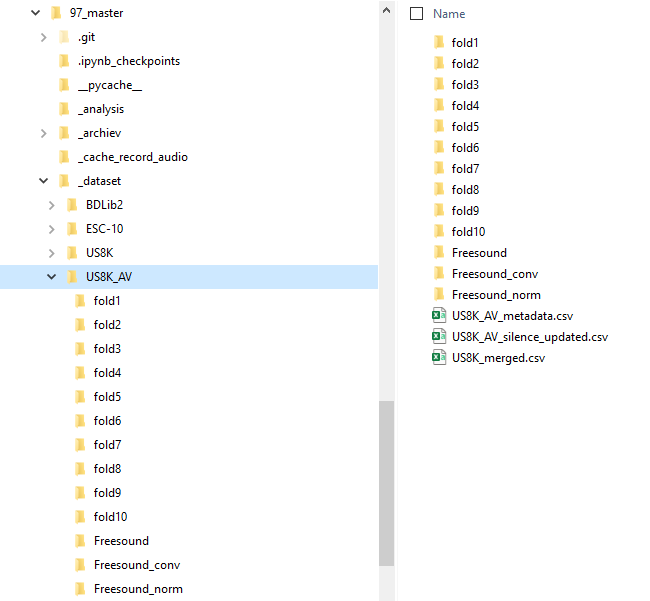

### US8K_AV statistics

In [53]:
db_new.columns

Index(['Fold', 'Folder_name', 'Class_OHEV', 'Class_categorical', 'File_name', 'Path', 'classID', 'fsID', 'start', 'end', 'salience'], dtype='object')

In [54]:
dfSilence.columns

Index(['Unnamed: 0', 'Fold', 'Folder_name', 'Class_categorical', 'File_name', 'Path'], dtype='object')

In [55]:
db_new

,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
4353,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
4354,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
4355,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
4356,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


In [58]:
dfSilenceUpd

,Fold,Folder_name,Class_categorical,File_name,Path
0,1,fold1,silence,107367-10-0-1.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-1.wav
1,1,fold1,silence,107367-10-0-10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-10.wav
2,1,fold1,silence,107367-10-0-11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-11.wav
3,1,fold1,silence,107367-10-0-12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-12.wav
4,1,fold1,silence,107367-10-0-13.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold1\107367-10-0-13.wav
...,...,...,...,...,...
545,9,fold9,silence,708192-10-0-10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-10.wav
546,9,fold9,silence,708192-10-0-11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-11.wav
547,9,fold9,silence,708192-10-0-12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-12.wav
548,9,fold9,silence,708192-10-0-8.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-8.wav


In [60]:
df4Features = db_new[['Fold', 'Folder_name', 'Class_categorical', 'File_name', 'Path']]
df4Features = pd.concat([df4Features,dfSilenceUpd], axis=0)
df4Features

,Fold,Folder_name,Class_categorical,File_name,Path
0,5,fold5,dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav
1,5,fold5,children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav
2,5,fold5,children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav
3,5,fold5,children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav
4,5,fold5,children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav
...,...,...,...,...,...
545,9,fold9,silence,708192-10-0-10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-10.wav
546,9,fold9,silence,708192-10-0-11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-11.wav
547,9,fold9,silence,708192-10-0-12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-12.wav
548,9,fold9,silence,708192-10-0-8.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-8.wav


In [61]:
# Method to create an one hot encoder vector (OHEV)

def OHEV(df: list, cat_class: str):
    
    df_class  = df[cat_class]
    
    return np.array(pd.get_dummies(df_class, columns = [str], dtype=int))

In [62]:
# Creates a OHEV for the audio classes

class_enc = OHEV(df4Features, 'Class_categorical')
df4Features.insert(loc = 2, column = 'Class_OHEV', value = class_enc.tolist())
df4Features

,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path
0,5,fold5,"[0, 0, 0, 1, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav
1,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav
2,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav
3,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav
4,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav
...,...,...,...,...,...,...
545,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-10.wav
546,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-11.wav
547,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-12.wav
548,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-8.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-8.wav


In [63]:
# Export the .CSV file that is going to be used in the next jupyter notebooks

exportCSV(path_US8K_AV, df4Features, csv_file)


CSV exported.
Check the folder C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV


In [64]:
df4FeaturesTemp = df4Features.copy()

In [65]:
# Lists to store sampling rates and durations

sampling_rates = []
durations      = []

# Iterate through each file path in the dataframe
for path in df4FeaturesTemp['Path']:
    # Load the audio file
    y, sr = librosa.load(path, sr=None)  # sr=None ensures the original sampling rate is preserved
    
    # Append sampling rate and duration to respective lists
    sampling_rates.append(sr)
    durations.append(librosa.get_duration(y=y, sr=sr))

# Add the new data to the dataframe
df4FeaturesTemp['Sampling_rate'] = sampling_rates
df4FeaturesTemp['Duration'] = durations

In [66]:
df4FeaturesTemp

,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path,Sampling_rate,Duration
0,5,fold5,"[0, 0, 0, 1, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav,44100,0.317551
1,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav,44100,4.000000
2,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav,44100,4.000000
3,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav,44100,4.000000
4,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav,44100,4.000000
...,...,...,...,...,...,...,...,...
545,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-10.wav,22050,4.000000
546,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-11.wav,22050,4.000000
547,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-12.wav,22050,4.000000
548,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-8.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-8.wav,22050,4.000000


In [67]:
def get_file_size_in_mb(file_path):
    file_size_bytes = os.path.getsize(file_path)
    file_size_mb = file_size_bytes / (1024 * 1024)  # Convert bytes to megabytes
    return file_size_mb

In [68]:
df4FeaturesTemp['Fold'] = df4FeaturesTemp['Fold'].astype(int)
df4FeaturesTemp_sorted  = df4FeaturesTemp.sort_values(by=['Fold'], ascending=True)
df4FeaturesTemp_sorted

,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path,Sampling_rate,Duration
2453,1,fold1,"[0, 0, 0, 1, 0, 0]",dog_bark,203440-3-0-6.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold1\203440-3-0-6.wav,44100,4.0
3761,1,fold1,"[0, 0, 0, 1, 0, 0]",dog_bark,72261-3-0-6.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold1\72261-3-0-6.wav,44100,4.0
3760,1,fold1,"[0, 0, 0, 1, 0, 0]",dog_bark,72261-3-0-27.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold1\72261-3-0-27.wav,44100,4.0
3759,1,fold1,"[0, 0, 0, 1, 0, 0]",dog_bark,72261-3-0-23.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold1\72261-3-0-23.wav,44100,4.0
3758,1,fold1,"[0, 0, 0, 1, 0, 0]",dog_bark,72261-3-0-17.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold1\72261-3-0-17.wav,44100,4.0
...,...,...,...,...,...,...,...,...
57,10,fold10,"[0, 0, 0, 0, 1, 0]",silence,655896-10-0-18.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold10\655896-10-0-18.wav,22050,4.0
58,10,fold10,"[0, 0, 0, 0, 1, 0]",silence,655896-10-0-19.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold10\655896-10-0-19.wav,22050,4.0
59,10,fold10,"[0, 0, 0, 0, 1, 0]",silence,655896-10-0-2.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold10\655896-10-0-2.wav,22050,4.0
1213,10,fold10,"[0, 0, 0, 0, 0, 1]",siren,159742-8-0-7.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold10\159742-8-0-7.wav,48000,4.0


In [69]:
statistics = []

for fold, group in df4FeaturesTemp_sorted.groupby('Fold'):
    
    folder_names  = group['Folder_name'].unique().tolist()
    
    num_files     = group.shape[0]
    
    total_size_mb = sum(get_file_size_in_mb(path) for path in group['Path'])
    
    unique_sampling_rates = group['Sampling_rate'].unique().tolist()
    
    avg_duration = group['Duration'].mean()
    
    statistics.append({
        'Fold': fold,
        'Folder_name': folder_names[0],
        'Number_of_files': num_files,
        'Total_size_MB': total_size_mb,
        'Min_Max_sampling_rates': [min(unique_sampling_rates),max(unique_sampling_rates)],
        'Average_duration': avg_duration
    })

# Convert the statistics to a DataFrame for better visualization
stats_df = pd.DataFrame(statistics)
stats_df['Total_size_MB']    = stats_df['Total_size_MB'].round(2)
stats_df['Average_duration'] = stats_df['Average_duration'].round(2)

In [70]:
stats_df

,Fold,Folder_name,Number_of_files,Total_size_MB,Min_Max_sampling_rates,Average_duration
0,1,fold1,478,350.26,"[8000, 96000]",3.59
1,2,fold2,485,334.86,"[11025, 96000]",3.58
2,3,fold3,536,332.36,"[11025, 96000]",3.68
3,4,fold4,599,422.08,"[11025, 96000]",3.63
4,5,fold5,529,334.56,"[16000, 96000]",3.62
5,6,fold6,460,276.28,"[11025, 96000]",3.62
6,7,fold7,465,299.23,"[11025, 96000]",3.69
7,8,fold8,441,279.12,"[8000, 192000]",3.58
8,9,fold9,447,312.98,"[11025, 96000]",3.61
9,10,fold10,468,328.68,"[11025, 96000]",3.62


In [71]:
df4FeaturesTemp_sorted[df4FeaturesTemp_sorted['Fold'] == 6]['Sampling_rate'].unique()

array([22050, 44100, 48000, 96000, 16000, 11025], dtype=int64)

In [72]:
print(df4FeaturesTemp_sorted['Sampling_rate'].unique())
print(max(df4FeaturesTemp_sorted['Sampling_rate'].unique()))
print(min(df4FeaturesTemp_sorted['Sampling_rate'].unique()))

[ 44100  11025  48000  22050   8000  24000  96000  16000  32000  11024
 192000]
192000
8000


In [73]:
sumSamples = stats_df['Number_of_files'].sum()
print(f'Total number of samples in the dataset: {sumSamples}')

Total number of samples in the dataset: 4908


In [74]:
sumSize = stats_df['Total_size_MB'].sum()
print(f'Total size of the dataset in MB: {sumSize}')

Total size of the dataset in MB: 3270.41


In [75]:
grouped_df = df4FeaturesTemp.groupby(['Class_categorical']).size().reset_index(name='counts')
grouped_df

,Class_categorical,counts
0,background,1000
1,car_horn,429
2,children_playing,1000
3,dog_bark,1000
4,silence,550
5,siren,929


In [76]:
def get_file_duration(file_path):
    y, sr = librosa.load(file_path)
    return librosa.get_duration(y=y, sr=sr)

duration_dict = {}

for class_name, group in df4FeaturesTemp.groupby('Class_categorical'):
    total_duration = sum(get_file_duration(file_path) for file_path in group['Path'])
    duration_dict[class_name] = total_duration

In [77]:
t = grouped_df[grouped_df['Class_categorical'] == 'background']['counts']
t[0]

1000

In [78]:
for i, (key, value) in enumerate(duration_dict.items()):
    print(f'{key}\nDuration...: {value/3600:.2f} hours')
    samples = grouped_df[grouped_df['Class_categorical'] == key]['counts']
    print(f'Samples....: {samples[i]}\n')

background
Duration...: 1.05 hours
Samples....: 1000

car_horn
Duration...: 0.29 hours
Samples....: 429

children_playing
Duration...: 1.10 hours
Samples....: 1000

dog_bark
Duration...: 0.87 hours
Samples....: 1000

silence
Duration...: 0.61 hours
Samples....: 550

siren
Duration...: 1.01 hours
Samples....: 929



In [79]:
print(f'Total duration of the dataset: {sum(duration_dict.values())/3600:.2f} hours')

Total duration of the dataset: 4.94 hours


In [80]:
# Exporting DataFrame to LaTeX format for the article in the journal Data in Brief

latex_code = stats_df.to_latex(index=False)

with open(os.path.join(path_US8K_AV, 'US8K_AV_table.tex'), 'w') as f:
    f.write(latex_code)

By the end of this chapter, the US8K_AV folder will have the following information:

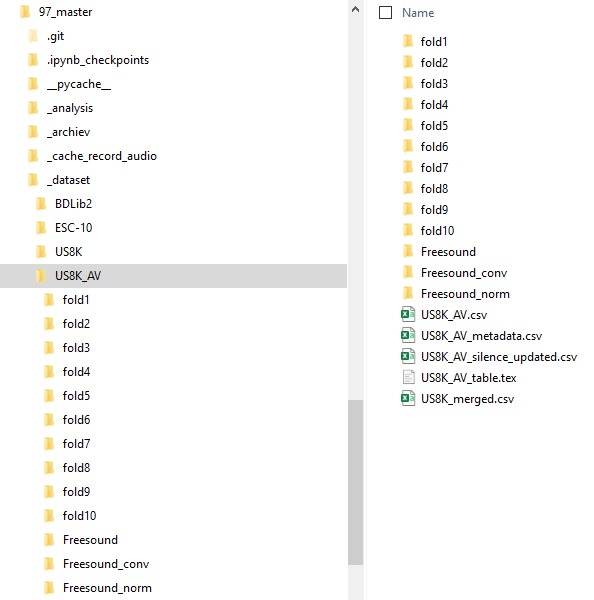

## Chapter 3.3 - Extracting the features for training the classifiers

**This part of the notebook requires a lot of allocation memory and is very time consuming.**

Take this in consideration before running the cells.

In [82]:
from MT_audioPP import audioPP
from MT_feature_extractor import feature_extractor

### Features ORIGINAL

* *aug*       = False
* *windowing* = False

In [83]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP_output = audioPP(df4Features['Path'].values,
                         df4Features['Class_categorical'].values, 
                         df4Features['Class_OHEV'].values,
                         df4Features['Fold'].values,
                         time_length = time_length,
                         threshold = threshold,
                         aug = False,
                         windowing = False,
                         frames = frames)
    
X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

100%|█████████████████████████████████████████████████████████████████████████████| 4908/4908 [00:38<00:00, 128.86it/s]
4908it [00:51, 95.03it/s] 


Shape of the audio data..................: (4908, 88200)
Shape of the categorical label data......: (4908,)
Shape of the one hot encoder label data..: (4908,)
Shape of the fold data...................: (4908,)


In [84]:
# Parse every OHEV list as numpy array of integers (int32)

#y_OHEV = np.array([np.array(sublist).astype(np.int32) for sublist in y_OHEV])
#y_OHEV = [np.array(eval(s)) for s in y_OHEV]

In [85]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug[['Fold']] = db_aug[['Fold']].astype('str')
db_aug

,Audio,Class_categorical,Class_OHEV,Fold
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0, 0]",5
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0, 0]",5
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0, 0]",5
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0, 0]",5
...,...,...,...,...
4903,"[0.0028076172, 0.0027770996, 0.0028686523, 0.0030212402, 0.0031738281, 0.0032043457, 0.003112793, 0.0029296875, 0.00...",silence,"[0, 0, 0, 0, 1, 0]",9
4904,"[-0.00076293945, -0.000579834, -0.00039672852, -0.00024414062, -0.00015258789, -0.00021362305, -0.0002746582, -0.000...",silence,"[0, 0, 0, 0, 1, 0]",9
4905,"[0.0005187988, 0.0002746582, 0.0, -0.00030517578, -0.0005187988, -0.000579834, -0.00045776367, -0.00021362305, -9.15...",silence,"[0, 0, 0, 0, 1, 0]",9
4906,"[-0.00030517578, -0.00033569336, -0.0002746582, -0.00015258789, 0.0, 0.00021362305, 0.00036621094, 0.00033569336, 0....",silence,"[0, 0, 0, 0, 1, 0]",9


In [86]:
# Convert the OHEV to int32
db_aug['Class_OHEV'] = db_aug['Class_OHEV'].apply(lambda x: eval(x) if isinstance(x, str) else x)
db_aug['Class_OHEV'] = db_aug['Class_OHEV'].apply(lambda x: np.array(x, dtype=np.int32))

In [87]:
for fold in np.unique(db_aug['Fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(db_aug[db_aug['Fold'] == fold])
    trnsize = len(db_aug[db_aug['Fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete_TRN size: {trnsize}')
    print()

Validation fold: 1
dbComplete_VAL size: 478
dbComplete_TRN size: 4430

Validation fold: 10
dbComplete_VAL size: 468
dbComplete_TRN size: 4440

Validation fold: 2
dbComplete_VAL size: 485
dbComplete_TRN size: 4423

Validation fold: 3
dbComplete_VAL size: 536
dbComplete_TRN size: 4372

Validation fold: 4
dbComplete_VAL size: 599
dbComplete_TRN size: 4309

Validation fold: 5
dbComplete_VAL size: 529
dbComplete_TRN size: 4379

Validation fold: 6
dbComplete_VAL size: 460
dbComplete_TRN size: 4448

Validation fold: 7
dbComplete_VAL size: 465
dbComplete_TRN size: 4443

Validation fold: 8
dbComplete_VAL size: 441
dbComplete_TRN size: 4467

Validation fold: 9
dbComplete_VAL size: 447
dbComplete_TRN size: 4461



In [88]:
dog_aug = db_aug[db_aug['Class_categorical'] == 'dog_bark']
dog_aug

,Audio,Class_categorical,Class_OHEV,Fold
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5
14,"[0.00016530929, 8.096441e-05, 0.00010344596, 9.4123185e-05, -1.7766375e-05, 3.42282e-05, 0.00016252033, 0.0001439824...",dog_bark,"[0, 0, 0, 1, 0, 0]",2
15,"[-0.0549016, -0.0030997097, 0.065438926, 0.066826925, 0.048625134, 0.00593441, 0.004272476, 0.033853546, 0.082438916...",dog_bark,"[0, 0, 0, 1, 0, 0]",2
16,"[-0.0013541959, -0.0017534851, -0.00066222204, -0.00073858444, -0.0018295386, -0.005036477, -0.007678789, -0.0046168...",dog_bark,"[0, 0, 0, 1, 0, 0]",2
17,"[-0.0021209174, -0.002075204, -0.00092535943, 0.00043941697, 0.004049227, 0.0050487723, 0.009374658, 0.009497762, 0....",dog_bark,"[0, 0, 0, 1, 0, 0]",2
...,...,...,...,...
4295,"[0.12224058, 0.28320754, 0.36700976, 0.47181457, 0.57441556, 0.64737153, 0.6197049, 0.5389351, 0.48762226, 0.4169649...",dog_bark,"[0, 0, 0, 1, 0, 0]",2
4296,"[-0.00022791978, -0.0012669582, -0.001694646, -0.0006031464, -0.0002898702, -0.00018023362, 0.00047345774, -0.000497...",dog_bark,"[0, 0, 0, 1, 0, 0]",2
4312,"[-0.00047976524, -0.00039484072, -0.00035502762, -0.00034532882, -0.0002325438, -0.00013316981, -9.567477e-06, -8.69...",dog_bark,"[0, 0, 0, 1, 0, 0]",6
4314,"[0.0028073888, 0.0015513706, -0.000205094, 0.0066186707, 0.005362046, 0.007070095, 0.009689612, 0.007504809, 0.01082...",dog_bark,"[0, 0, 0, 1, 0, 0]",10


In [89]:
print(type(db_aug['Class_OHEV'][0]))
print(type(db_aug['Class_OHEV'][0][0]))

<class 'numpy.ndarray'>
<class 'numpy.int32'>


In [90]:
random_idx = random.choice(dog_aug.index.tolist())
random_sample = dog_aug['Audio'][random_idx]
print(f'Dataframe index....: {random_idx}')
print(f'Sample path........: {dog_aug["Fold"][random_idx]}')
print(f'Sample audio.......: {random_sample}')

Dataframe index....: 2358
Sample path........: 3
Sample audio.......: [-0.10979922 -0.20085263 -0.17367971 ...  0.00436146  0.00692903
  0.00889406]


In [91]:
ipd.Audio(random_sample, rate = SR)

In [92]:
pkl_features

'US8K_AV_features_original.pkl'

In [93]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_original  = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_original.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_original.fillna(0, inplace=True)

    # Save the features to a pickle file (~1,514GB)
    DB_original.to_pickle(os.path.join(path_models, pkl_features))
    
    # Read the features from the pickle file
    DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

# If exist, read the pkl file with the features extracted
else:
    DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

In [94]:
DB_ori_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,...,0.024244,-0.049756,0.759231,-0.024962
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.018670,-0.018241,0.275013,-0.497943
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.018733,0.009139,-0.205466,-0.212879
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.027117,0.007208,-0.769827,0.623153
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.025776,0.050245,0.208739,-1.062755
...,...,...,...,...,...,...,...,...,...
4903,"[0.0020684754, 0.002996013, 0.0027406309, 0.0031264792, 0.0030979805, 0.0032640784, 0.0030700786, 0.0029712087, 0.00...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.046910,-0.014152,1.014088,0.288518
4904,"[-0.00054763607, -0.0006439837, -0.0003565054, -0.00026786933, -0.00012919167, -0.0002218535, -0.00025803095, -0.000...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.048725,0.003801,-0.290986,-1.009455
4905,"[0.00036112632, 0.0003222265, -2.3932662e-05, -0.00028421593, -0.0005354925, -0.0005733533, -0.00046778092, -0.00020...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.032608,-0.043836,1.350900,2.272794
4906,"[-0.0002325126, -0.00035913184, -0.00025248923, -0.0001690893, 1.3734563e-05, 0.00021053397, 0.0003744613, 0.0003582...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.026508,-0.003402,-0.001074,-0.871445


In [95]:
print(type(DB_ori_from_pkl['Fold'][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [96]:
print(len(DB_ori_from_pkl))

4908


In [97]:
DB_ori_from_pkl.shape

(4908, 379)

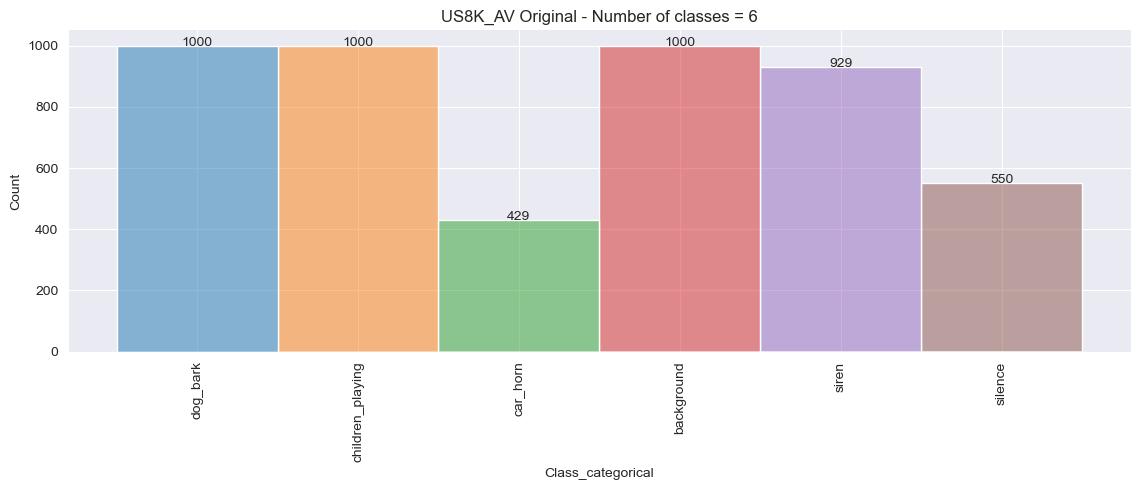

In [98]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Original - Number of classes = ' + str(len(pd.Series(DB_ori_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_ori_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

### Features AUGMENTED

* *aug*       = True
* *windowing* = False

Dataset will be 6x larger (original + time stretching .85 / 1.15, pitch shifting -4 / +4 semitons, and time shifting randomly)

ATTENTION: you may need to split this process in more than 2 steps due memory allocation constrains

In [99]:
for i in range(2):
    subset_db = df4Features[int(i*len(df4Features)/2):int((i+1)*len(df4Features)/2)]

    audioPP_output = audioPP(subset_db['Path'].values,
                             subset_db['Class_categorical'].values, 
                             subset_db['Class_OHEV'].values,
                             subset_db['Fold'].values,
                             time_length = time_length,
                             threshold = threshold,
                             aug = True,
                             windowing = False,
                             frames = frames)

    X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

    # Delete the subsets to clear memory
    del subset_db 

    db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
    db_aug[['Fold']] = db_aug[['Fold']].astype('str')
    
    del X, y_string, y_OHEV, folds # Delete to clear memory

    # Save db_aug as a pickle file
    with open(os.path.join(path_models, f'db_aug_{i+1}.pkl'), 'wb') as f:
        pickle.dump(db_aug, f)

    del db_aug  # Delete db_aug to clear memory

# Read and join both db_aug_1 and db_aug_2 into db_aug
with open(os.path.join(path_models,'db_aug_1.pkl'), 'rb') as f:
    db_aug_1 = pickle.load(f)

with open(os.path.join(path_models,'db_aug_2.pkl'), 'rb') as f:
    db_aug_2 = pickle.load(f)

db_aug = pd.concat([db_aug_1, db_aug_2], ignore_index=True)

del db_aug_1, db_aug_2
os.remove(os.path.join(path_models,'db_aug_1.pkl'))
os.remove(os.path.join(path_models,'db_aug_2.pkl'))

100%|██████████████████████████████████████████████████████████████████████████████| 2454/2454 [08:06<00:00,  5.04it/s]
14724it [03:31, 69.64it/s] 


Shape of the audio data..................: (14724, 88200)
Shape of the categorical label data......: (14724,)
Shape of the one hot encoder label data..: (14724, 6)
Shape of the fold data...................: (14724,)


100%|██████████████████████████████████████████████████████████████████████████████| 2454/2454 [13:20<00:00,  3.07it/s]
14724it [03:37, 67.73it/s] 


Shape of the audio data..................: (14724, 88200)
Shape of the categorical label data......: (14724,)
Shape of the one hot encoder label data..: (14724, 6)
Shape of the fold data...................: (14724,)


In [100]:
db_aug

,Audio,Class_categorical,Class_OHEV,Fold
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5
1,"[-0.00030852175203299943, 0.000343655680109799, -0.00022448088284122373, 0.0008418381950042633, 0.000888766950021404...",dog_bark,"[0, 0, 0, 1, 0, 0]",5
2,"[-0.0035122973, -0.0050051752, -0.0045919046, -0.0048774146, -0.0037652655, -0.0022669514, -0.00015891435, 0.0014704...",dog_bark,"[0, 0, 0, 1, 0, 0]",5
3,"[-0.003488453, -0.004396054, -0.0037757251, -0.0042094756, -0.0030081559, -0.0015460963, 0.00081547524, 0.0026281716...",dog_bark,"[0, 0, 0, 1, 0, 0]",5
4,"[-0.003237898, -0.0050192326, -0.0046117576, -0.004234772, -0.0019701908, 0.00027243508, 0.0026218973, 0.004221949, ...",dog_bark,"[0, 0, 0, 1, 0, 0]",5
...,...,...,...,...
29443,"[-0.0002068523183414091, 0.0006055250529198514, -0.0007205078744223316, -0.0001810100409626263, 0.000529873897844533...",silence,"[0, 0, 0, 0, 1, 0]",9
29444,"[0.0035992481, 0.0036344882, 0.0036928218, 0.0037312587, 0.003703511, 0.003547089, 0.0032673157, 0.0029896013, 0.002...",silence,"[0, 0, 0, 0, 1, 0]",9
29445,"[0.0035160903, 0.0035866154, 0.003644765, 0.003671189, 0.0036451623, 0.003500947, 0.0032332472, 0.0029624582, 0.0028...",silence,"[0, 0, 0, 0, 1, 0]",9
29446,"[0.0030563194, 0.0038591959, 0.0036011066, 0.0038392614, 0.003461575, 0.003268153, 0.002824441, 0.00288036, 0.002727...",silence,"[0, 0, 0, 0, 1, 0]",9


In [101]:
# Convert the OHEV to int32
db_aug['Class_OHEV'] = db_aug['Class_OHEV'].apply(lambda x: eval(x) if isinstance(x, str) else x)
db_aug['Class_OHEV'] = db_aug['Class_OHEV'].apply(lambda x: np.array(x, dtype=np.int32))

In [102]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [103]:
db_aug['Audio'][random_idx*6] # 6x due augmentation to get the same sample as the original

array([-0.10979922, -0.20085263, -0.17367971, ...,  0.00436146,
        0.00692903,  0.00889406], dtype=float32)

In [104]:
ipd.Audio(random_sample, rate = SR)

In [105]:
ipd.Audio(db_aug.at[random_idx*6 + 1, 'Audio'], rate = SR) # First augmentation of the original audio

In [106]:
librosa.get_duration(y = db_aug['Audio'][random_idx*6 + 1]) # 6x due augmentation to get the same sample as the original

4.0

In [107]:
pkl_aug_features

'US8K_AV_features_augmented_no_windowing.pkl'

In [108]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_aug_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_augmented = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_augmented.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_augmented.fillna(0, inplace=True)
    
    # Save the features to a pickle file (~10,588GB)
    DB_augmented.to_pickle(os.path.join(path_models, pkl_aug_features))
    
    # Read the features from the pickle file
    DB_aug_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_features))

# If exist, read the pkl file with the features extracted
else:
    DB_aug_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_features))

In [109]:
DB_aug_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,...,0.024244,-0.049756,0.759231,-0.024962
1,"[-0.06878060102462769, -0.07955734431743622, -0.06831151247024536, -0.01678953319787979, 0.04453383386135101, 0.1219...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,...,0.026310,-0.040049,0.006524,-1.139639
2,"[-0.0035122973, -0.0050051752, -0.0045919046, -0.0048774146, -0.0037652655, -0.0022669514, -0.00015891435, 0.0014704...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,...,0.031054,-0.028243,0.298586,-0.490271
3,"[-0.003488453, -0.004396054, -0.0037757251, -0.0042094756, -0.0030081559, -0.0015460963, 0.00081547524, 0.0026281716...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,...,0.025748,-0.000898,-0.077263,-0.095841
4,"[-0.003237898, -0.0050192326, -0.0046117576, -0.004234772, -0.0019701908, 0.00027243508, 0.0026218973, 0.004221949, ...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,...,0.027486,0.031821,-0.303592,0.219901
...,...,...,...,...,...,...,...,...,...
29443,"[-0.00012672941387911198, -0.00031067112901529725, 0.00037769022446324657, -0.0009935621503807308, -0.00088722864425...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.027833,-0.001339,0.313543,-0.243855
29444,"[0.0026603942, 0.0039245826, 0.0035142228, 0.0038491564, 0.0036104622, 0.0036268367, 0.0032049355, 0.0030404173, 0.0...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.020392,-0.012396,-0.301014,0.615277
29445,"[0.0026129675, 0.003855708, 0.003475815, 0.0037853124, 0.0035560108, 0.0035760163, 0.0031735122, 0.003010428, 0.0027...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.027290,-0.000766,0.396965,-0.319961
29446,"[0.002469795, 0.0039433176, 0.003568492, 0.0038429683, 0.0034739408, 0.0032530972, 0.0028426645, 0.0028493577, 0.002...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.030069,0.024746,0.303463,-0.394982


In [110]:
print(type(DB_aug_from_pkl['Fold'][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [111]:
print(len(DB_aug_from_pkl))

29448


In [112]:
DB_aug_from_pkl.shape

(29448, 379)

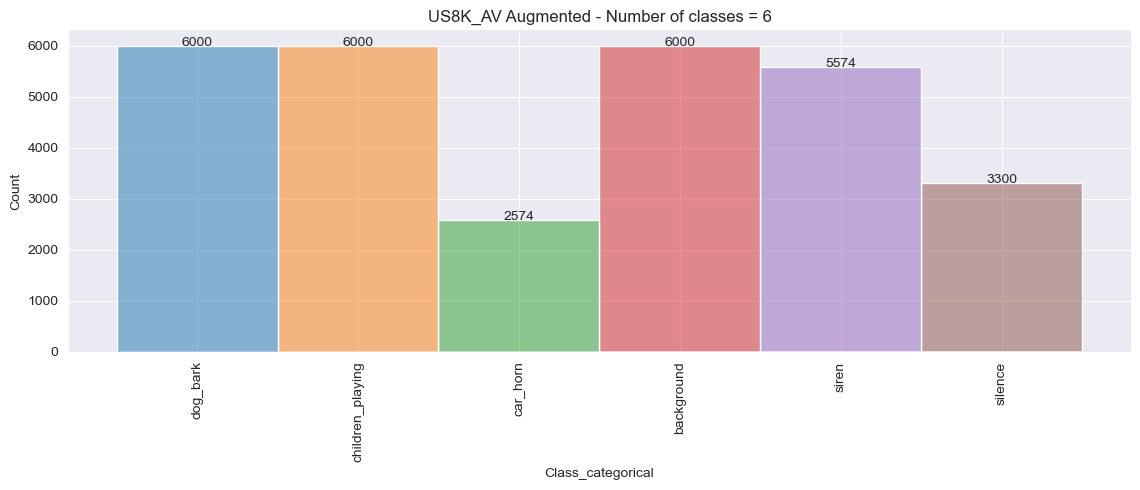

In [113]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Augmented - Number of classes = ' + str(len(pd.Series(DB_aug_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

### Features AUGMENTED and WINDOWED

* *aug*       = False
* *windowing* = True

Dataset will have 4,908 * 7 = 34,356 samples.

ATTENTION: you may need to split this process due memory allocation constrains

In [114]:
# Clear the memory
del db_aug, DB_ori_from_pkl, DB_aug_from_pkl

In [115]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP_output = audioPP(df4Features['Path'].values,
                         df4Features['Class_categorical'].values, 
                         df4Features['Class_OHEV'].values,
                         df4Features['Fold'].values,
                         time_length = time_length,
                         threshold = threshold,
                         aug = False,
                         windowing = True,
                         frames = frames)
    
X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

100%|██████████████████████████████████████████████████████████████████████████████| 4908/4908 [02:25<00:00, 33.78it/s]
4908it [01:39, 49.38it/s]
100%|███████████████████████████████████████████████████████████████████████████| 4908/4908 [00:00<00:00, 27451.59it/s]


Shape of the audio data..................: (34356, 22016)
Shape of the categorical label data......: (34356,)
Shape of the one hot encoder label data..: (34356, 6)
Shape of the fold data...................: (34356,)


In [118]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug[['Fold']] = db_aug[['Fold']].astype('str')

In [119]:
# Convert the OHEV to int32
db_aug['Class_OHEV'] = db_aug['Class_OHEV'].apply(lambda x: np.array(x, dtype=np.int32))

In [120]:
# Convert the OHEV to int32
db_aug['Class_OHEV'] = db_aug['Class_OHEV'].apply(lambda x: eval(x) if isinstance(x, str) else x)
db_aug['Class_OHEV'] = db_aug['Class_OHEV'].apply(lambda x: np.array(x, dtype=np.int32))

In [121]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [122]:
ipd.Audio(random_sample, rate = SR)

In [123]:
random_idx

2358

In [124]:
print(librosa.get_duration(y = db_aug.at[random_idx * 1 * 7, 'Audio']))
ipd.Audio(db_aug.at[random_idx * 1 * 7, 'Audio'], rate = SR)

0.9984580498866213


In [125]:
pkl_aug_wind_features

'US8K_AV_features_windowed.pkl'

In [ ]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_aug_wind_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_aug_wind  = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_aug_wind.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_aug_wind.fillna(0, inplace=True)
    
    # Save the features to a pickle file (~2,714GB)
    DB_aug_wind.to_pickle(os.path.join(path_models, pkl_aug_wind_features)) 
    
    # Read the features from the pickle file
    DB_aug_wind_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))

# If exist, read the pkl file with the features extracted
else:
    DB_aug_wind_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))

In [ ]:
DB_aug_wind_from_pkl

In [ ]:
print(type(DB_aug_wind_from_pkl['Fold'][0]))
print(type(DB_aug_wind_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_wind_from_pkl['Class_OHEV'][0]))

In [ ]:
print(len(DB_aug_wind_from_pkl))

In [ ]:
DB_aug_wind_from_pkl.shape

In [ ]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Augmented and windowed - Number of classes = ' + str(len(pd.Series(DB_aug_wind_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_wind_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

# End of notebook